In [1]:
pip install medmnist

In [40]:
import medmnist
print(medmnist.__version__)


3.0.2


In [43]:
from medmnist import INFO

data_flag = 'octmnist'
info = INFO[data_flag]

print("Description:\n", info['description'])
print("\nTask Type:", info['task'])
print("\nNumber of Labels:", len(info['label']))
print("\nLabel Mapping:", info['label'])


info = INFO['octmnist']
print(info)


#PettyPrinting
#I have used pprint of info which basically gives infromation about all the classes present int eh OCTMNIST dataset
#having 109,309 record out of which the distrubution of training and testing and validation splits seems pretty imbalanced
#it also has 4 classes


from pprint import pprint
pprint(info)


Description:
 The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.

Task Type: multi-class

Number of Labels: 4

Label Mapping: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
{'python_class': 'OCTMNIST', 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and

In [44]:
#Store the values of OCTMNIST from the python class
DataClass = getattr(medmnist, info['python_class'])  # dataset class


# Load datasets
train_dataset = DataClass(split='train', download=True, transform=None)
val_dataset   = DataClass(split='val', download=True, transform=None)
test_dataset  = DataClass(split='test', download=True, transform=None)

In [45]:
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("Number of classes:", len(info['label']))
print("Class labels:", info['label'])

Train samples: 97477
Validation samples: 10832
Test samples: 1000
Number of classes: 4
Class labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}


3 Visualizations


In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Plot samples based on the number of classes available

train_labels = train_dataset.labels.flatten()
plt.figure(figsize=(6,4))
plt.hist(train_labels, bins=np.arange(len(info['label'])+1)-0.5, rwidth=0.6, color='skyblue')
plt.xticks(range(len(info['label'])), info['label'])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Distribution in Training Set')
plt.show()



As mentioned above while petty printing, the dataset is slightly imbalanced. CNV (3)has the most samples while DRUSEN(2) has the fewest. This might require class balancing techniques during training.

In [48]:
#Plotting from images from training dataset

plt.figure(figsize=(12,4))
for i in range(8):
    img, label = train_dataset[i]

    # Convert label to scalar
    if isinstance(label, np.ndarray):
        label = label.squeeze()

    plt.subplot(2,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(info['label'][str(label)])  # keys are strings
    plt.axis('off')
plt.suptitle('Sample Images from Training Set')
plt.show()



Images are small grayscale pixels. Features are subtle, so we might have to rotations, flips have to be used incase the accuracy is not properlyreached

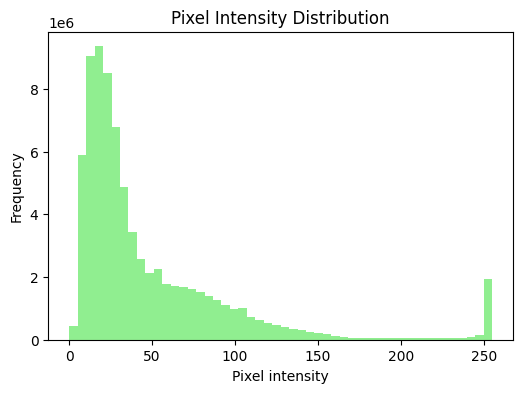

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Convert PIL images to numpy arrays and flatten
all_pixels = np.array([np.array(img).flatten() for img, _ in train_dataset])

plt.figure(figsize=(6,4))
plt.hist(all_pixels.flatten(), bins=50, color='lightgreen')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()


Most pixels have mid-range intensity,which i s indicating good contrast. Normalising into [0,1] can be helpful


In [50]:
#Converting the pixed range from 0-255 to 0-1 to keep it standardized

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
])




In [51]:

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels), #Declared train_labels where we converted train data into 1d flatten
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)


Class weights: tensor([0.7278, 2.3861, 3.1428, 0.5295])


In [11]:
#Implementing one hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
labels_onehot = encoder.fit_transform(train_labels.reshape(-1,1))
#Above code converts back the code from 1d to 2d

print(labels_onehot.shape)
print(labels_onehot[:5])


(97477, 4)
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [53]:
#Since the dataset split is highly imbalanced , as per discussion
#made changed to the splitting of the data

from sklearn.model_selection import train_test_split


#all_data = np.concatenate([train_dataset.imgs, val_dataset.imgs, test_dataset.imgs], axis=1)

all_data = np.concatenate([train_dataset.imgs, val_dataset.imgs, test_dataset.imgs], axis=0)


#Combine data as well
all_labels = np.concatenate([train_dataset.labels, val_dataset.labels, test_dataset.labels], axis=0)

X_train, X_temp, y_train, y_temp = train_test_split(all_data, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, stratify=y_temp, random_state=42)




In [54]:
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 76516
Validation set size: 10821
Test set size: 21972


Step 2: Defining the Neural Network

## Neural Network Architecture Definition

### Input Neurons
- **Input neurons:** Image as mentioned is given as  28×28 pixels  

### Output Neurons
- **Output neurons:** Since we have 4 classes we know that there will be 4 neurons in the output layer.

### Activation Functions
- **Hidden layers:** ReLU
- **Output layer:** Softmax `nn.CrossEntropyLoss`

### Number of Hidden Layers
- For base model i have used :
- 2 convolutional layers  1 fully connected hidden layer

### Layer Sizes and Dropout
**Convolutional layers:**  
- Conv1: 1 → 32 filters  
- Conv2: 32 → 64 filters  

**Fully connected layer:**  
- 64 × 7 × 7 → 128 neurons  

**Dropout:**  
- Keeping the dropout value same initally, based on test results will eventually decrease
- After conv layers: nn.Dropout2d(p=0.5)`
- After fully connected layer: nn.Dropout(p=0.5)

### Reasoning / Description
- The network is small enough to train quickly on 28×28 images but powerful enough to learn complex retinal patterns.  
- RELU will help ensure  fast convergence.  
- Dropoutprevents overfitting , ideally should not be high considering spliiting of dataset.  
- The fully connected layer flattens and compresses features for classification.


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OCTNet(nn.Module):
    def __init__(self, num_classes=4, dropout_p=0.5):
        super(OCTNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)


        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        #Applying pooling (2,2)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout layers
        self.dropout_conv = nn.Dropout2d(p=dropout_p)
        self.dropout_fc = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [56]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = OCTNet(num_classes=4).to(device)

summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 4]             516
Total params: 420,868
Trainable params: 420,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
-------------------------------------------

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import seaborn as sns
import time


In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


Device: cuda


In [59]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)/255.0  # add channel dim
y_train_tensor = torch.tensor(y_train.flatten(), dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)/255.0
y_val_tensor = torch.tensor(y_val.flatten(), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)/255.0
y_test_tensor = torch.tensor(y_test.flatten(), dtype=torch.long)

print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)


X_train_tensor shape: torch.Size([76516, 1, 28, 28])
y_train_tensor shape: torch.Size([76516])
X_val_tensor shape: torch.Size([10821, 1, 28, 28])
y_val_tensor shape: torch.Size([10821])
X_test_tensor shape: torch.Size([21972, 1, 28, 28])
y_test_tensor shape: torch.Size([21972])


In [60]:

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
#Setting the model
model = OCTNet(num_classes=4, dropout_p=0.5).to(device)

# Class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
labels_train = y_train.flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
#Using Adam
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # weight_decay for regularization


Training

In [62]:
num_epochs = 30
patience = 5  # early stopping patience
best_val_loss = np.inf
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()
#have used a smiliar model for ML assignment , so making slight changes to the code of trainign and test evaluation based on requirement

for epoch in range(num_epochs):
    #Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

end_time = time.time()
print(f"Training completed in {(end_time-start_time)/60:.2f} minutes")


Epoch 1/30 | Train Loss: 1.3216, Train Acc: 0.4236 | Val Loss: 1.0768, Val Acc: 0.6925
Epoch 2/30 | Train Loss: 1.0590, Train Acc: 0.6323 | Val Loss: 0.8038, Val Acc: 0.7835
Epoch 3/30 | Train Loss: 0.9220, Train Acc: 0.6777 | Val Loss: 0.7301, Val Acc: 0.7960
Epoch 4/30 | Train Loss: 0.8643, Train Acc: 0.6979 | Val Loss: 0.6899, Val Acc: 0.7913
Epoch 5/30 | Train Loss: 0.8317, Train Acc: 0.7041 | Val Loss: 0.6647, Val Acc: 0.7795
Epoch 6/30 | Train Loss: 0.8054, Train Acc: 0.7143 | Val Loss: 0.6509, Val Acc: 0.7862
Epoch 7/30 | Train Loss: 0.7913, Train Acc: 0.7148 | Val Loss: 0.6302, Val Acc: 0.7860
Epoch 8/30 | Train Loss: 0.7780, Train Acc: 0.7195 | Val Loss: 0.6096, Val Acc: 0.7954
Epoch 9/30 | Train Loss: 0.7652, Train Acc: 0.7222 | Val Loss: 0.6222, Val Acc: 0.8137
Epoch 10/30 | Train Loss: 0.7567, Train Acc: 0.7265 | Val Loss: 0.5980, Val Acc: 0.8211
Epoch 11/30 | Train Loss: 0.7458, Train Acc: 0.7282 | Val Loss: 0.5779, Val Acc: 0.8231
Epoch 12/30 | Train Loss: 0.7424, Train A

In [63]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)


all_labels = np.array(all_labels)

# Accuracy
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Test Accuracy: 0.8304
Precision: 0.8577, Recall: 0.8304, F1 Score: 0.8412


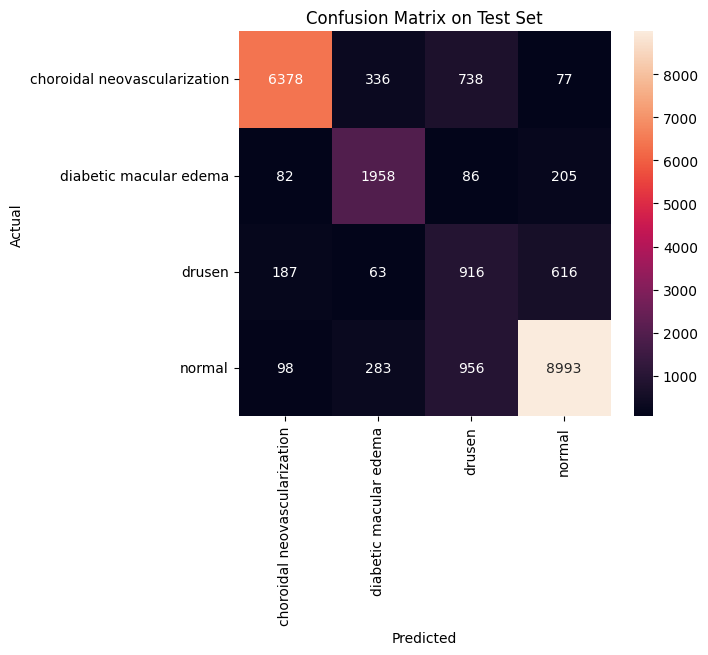

In [64]:
#Plot the confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(info['label'].values()), yticklabels=list(info['label'].values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [65]:
# For test set, replicate value to match epochs
test_accs = [test_acc]*len(train_accs)
test_losses = [0]*len(train_losses)  # if test loss not computed per epoch




In [66]:
# Accuracy
plt.figure(figsize=(8,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.plot(test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


We can say that from the above that the training model was initally not doing well, and as epochs it started it doing better, validation was already on the higher side and for the test it has mentioned a constant sicne we have just predicted on the test set and no epochs so straight line

In [67]:

# Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

We can say that from the above that the training model the loss was high and almost was the same with validation loss, however over time as decreased and makes it perfect because we have overuled the effect of overfitting

In [23]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(all_labels, classes=[0,1,2,3])
y_score = []

model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        y_score.append(probs.cpu().numpy())

y_score = np.vstack(y_score)

# Plot ROC per class
plt.figure(figsize=(8,6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{info['label'][str(i)]} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend()
plt.show()


The model performs excellently for most classes with AUC > 0.95, effectively distinguishing positives from negatives.
Drusen has a slightly lower AUC (0.88), indicating some confusion with similar retinal conditions.


Method 1: Learning Rate Scheduler

In [69]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model2 = OCTNet(num_classes=4, dropout_p=0.5).to(device)

optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


Same approach for training and then validation for model 2

In [70]:
num_epochs = 30
patience = 5  # early stopping patience
best_val_loss_2 = np.inf
epochs_no_improve_2 = 0

train_losses_2, val_losses_2 = [], []
train_accs_2, val_accs_2 = [], []

start_time_2 = time.time()

for epoch in range(num_epochs):
    #Training
    model2.train()
    running_loss_2, correct_2, total_2 = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_2 += loss.item() * imgs.size(0)
        _, predicted_2 = torch.max(outputs, 1)
        correct_2 += (predicted_2 == labels).sum().item()
        total_2 += labels.size(0)

    train_loss_2 = running_loss_2 / total_2
    train_acc_2 = correct_2 / total_2
    train_losses_2.append(train_loss_2)
    train_accs_2.append(train_acc_2)

    #Validation
    model2.eval()
    val_running_loss_2, val_correct_2, val_total_2 = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)

            val_running_loss_2 += loss.item() * imgs.size(0)
            _, predicted_val_2 = torch.max(outputs, 1)
            val_correct_2 += (predicted_val_2 == labels).sum().item()
            val_total_2 += labels.size(0)

    val_loss_2 = val_running_loss_2 / val_total_2
    val_acc_2 = val_correct_2 / val_total_2
    val_losses_2.append(val_loss_2)
    val_accs_2.append(val_acc_2)

    #Adding scheduler
    scheduler.step(val_loss_2)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss_2:.4f}, Train Acc: {train_acc_2:.4f} | "
          f"Val Loss: {val_loss_2:.4f}, Val Acc: {val_acc_2:.4f}")

    #Early stopping
    if val_loss_2 < best_val_loss_2:
        best_val_loss_2 = val_loss_2
        epochs_no_improve_2 = 0
        torch.save(model2.state_dict(), "best_model2.pth")
    else:
        epochs_no_improve_2 += 1
        if epochs_no_improve_2 >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

end_time_2 = time.time()
print(f"Training completed in {(end_time_2-start_time_2)/60:.2f} minutes")


Epoch 1/30 | Train Loss: 1.3345, Train Acc: 0.4331 | Val Loss: 1.1293, Val Acc: 0.6864
Epoch 2/30 | Train Loss: 1.0897, Train Acc: 0.6219 | Val Loss: 0.8498, Val Acc: 0.7616
Epoch 3/30 | Train Loss: 0.9459, Train Acc: 0.6655 | Val Loss: 0.7516, Val Acc: 0.7587
Epoch 4/30 | Train Loss: 0.8805, Train Acc: 0.6891 | Val Loss: 0.6959, Val Acc: 0.7693
Epoch 5/30 | Train Loss: 0.8387, Train Acc: 0.6991 | Val Loss: 0.6715, Val Acc: 0.7922
Epoch 6/30 | Train Loss: 0.8104, Train Acc: 0.7073 | Val Loss: 0.6502, Val Acc: 0.7984
Epoch 7/30 | Train Loss: 0.7900, Train Acc: 0.7119 | Val Loss: 0.6304, Val Acc: 0.7931
Epoch 8/30 | Train Loss: 0.7794, Train Acc: 0.7150 | Val Loss: 0.6128, Val Acc: 0.8044
Epoch 9/30 | Train Loss: 0.7677, Train Acc: 0.7220 | Val Loss: 0.6090, Val Acc: 0.7977
Epoch 10/30 | Train Loss: 0.7638, Train Acc: 0.7215 | Val Loss: 0.6046, Val Acc: 0.8156
Epoch 11/30 | Train Loss: 0.7485, Train Acc: 0.7255 | Val Loss: 0.5897, Val Acc: 0.7994
Epoch 12/30 | Train Loss: 0.7459, Train A

Test Accuracy (Model 2): 0.8251
Precision: 0.8685, Recall: 0.8251, F1 Score: 0.8406


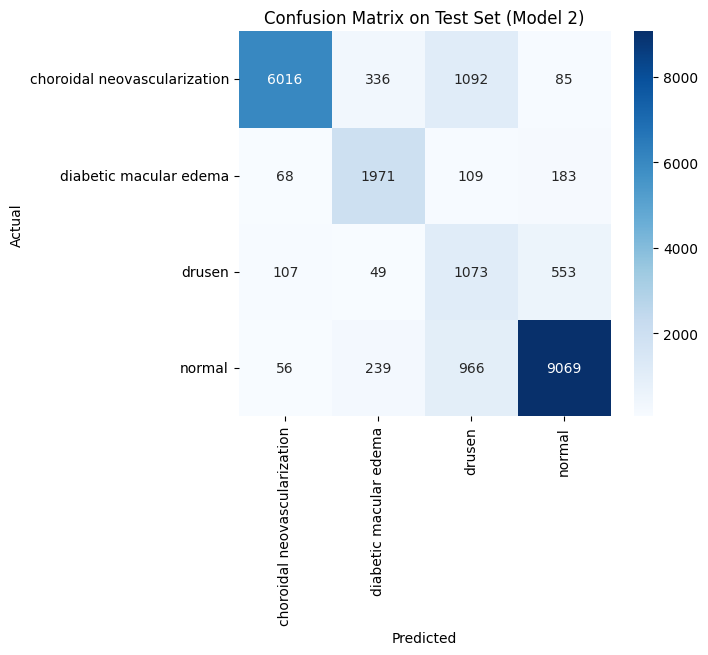

In [71]:
model2.load_state_dict(torch.load("best_model2.pth"))
model2.eval()  # set to evaluation mode

all_preds_2 = []
all_labels_2 = []

with torch.no_grad():  # no gradient needed for testing
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model2(imgs)
        _, predicted_2 = torch.max(outputs, 1)  # get class with highest score
        all_preds_2.extend(predicted_2.cpu().numpy())
        all_labels_2.extend(labels.cpu().numpy())

all_preds_2 = np.array(all_preds_2)
all_labels_2 = np.array(all_labels_2)



# Accuracy
test_acc_2 = accuracy_score(all_labels_2, all_preds_2)
precision_2, recall_2, f1_2, _ = precision_recall_fscore_support(all_labels_2, all_preds_2, average='weighted')

print(f"Test Accuracy (Model 2): {test_acc_2:.4f}")
print(f"Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1 Score: {f1_2:.4f}")

# Confusion Matrix
cm_2 = confusion_matrix(all_labels_2, all_preds_2)
plt.figure(figsize=(6,5))
sns.heatmap(cm_2, annot=True, fmt='d',
            xticklabels=list(info['label'].values()),
            yticklabels=list(info['label'].values()), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set (Model 2)')
plt.show()


Model 3

In [75]:


class OCTNet_3Conv(nn.Module):
    def __init__(self, num_classes=4, dropout_p=0.5):
        super(OCTNet_3Conv, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        #Creating a one more conv3 layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2,2)

        # Fully connected layers
        self.fc1 = nn.Linear(128*3*3, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout_conv = nn.Dropout2d(p=dropout_p)
        self.dropout_fc = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [76]:
model3 = OCTNet_3Conv(num_classes=4, dropout_p=0.5).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [77]:
num_epochs = 20
patience = 3  # early stopping patience
best_val_loss_3 = np.inf
epochs_no_improve_3 = 0

train_losses_3, val_losses_3 = [], []
train_accs_3, val_accs_3 = [], []

start_time_3 = time.time()

for epoch in range(num_epochs):
    #Training
    model3.train()
    running_loss_3, correct_3, total_3 = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_3 += loss.item() * imgs.size(0)
        _, predicted_3 = torch.max(outputs, 1)
        correct_3 += (predicted_3 == labels).sum().item()
        total_3 += labels.size(0)

    train_loss_3 = running_loss_3 / total_3
    train_acc_3 = correct_3 / total_3
    train_losses_3.append(train_loss_3)
    train_accs_3.append(train_acc_3)

    # Validation
    model3.eval()
    val_running_loss_3, val_correct_3, val_total_3 = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model3(imgs)
            loss = criterion(outputs, labels)

            val_running_loss_3 += loss.item() * imgs.size(0)
            _, predicted_3 = torch.max(outputs, 1)
            val_correct_3 += (predicted_3 == labels).sum().item()
            val_total_3 += labels.size(0)

    val_loss_3 = val_running_loss_3 / val_total_3
    val_acc_3 = val_correct_3 / val_total_3
    val_losses_3.append(val_loss_3)
    val_accs_3.append(val_acc_3)

    #Scheduler step
    scheduler.step(val_loss_3)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss_3:.4f}, Train Acc: {train_acc_3:.4f} | "
          f"Val Loss: {val_loss_3:.4f}, Val Acc: {val_acc_3:.4f}")

    # Early stopping
    if val_loss_3 < best_val_loss_3:
        best_val_loss_3 = val_loss_3
        epochs_no_improve_3 = 0
        torch.save(model3.state_dict(), "best_model3.pth")
    else:
        epochs_no_improve_3 += 1
        if epochs_no_improve_3 >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

end_time_3 = time.time()
print(f"Training completed in {(end_time_3 - start_time_3)/60:.2f} minutes")


Epoch 1/20 | Train Loss: 1.2368, Train Acc: 0.4909 | Val Loss: 0.9598, Val Acc: 0.7558
Epoch 2/20 | Train Loss: 0.9692, Train Acc: 0.6700 | Val Loss: 0.8070, Val Acc: 0.7893
Epoch 3/20 | Train Loss: 0.8809, Train Acc: 0.7005 | Val Loss: 0.6858, Val Acc: 0.7874
Epoch 4/20 | Train Loss: 0.8354, Train Acc: 0.7097 | Val Loss: 0.6441, Val Acc: 0.8041
Epoch 5/20 | Train Loss: 0.8028, Train Acc: 0.7229 | Val Loss: 0.6265, Val Acc: 0.8275
Epoch 6/20 | Train Loss: 0.7814, Train Acc: 0.7241 | Val Loss: 0.6183, Val Acc: 0.8158
Epoch 7/20 | Train Loss: 0.7606, Train Acc: 0.7327 | Val Loss: 0.6244, Val Acc: 0.8112
Epoch 8/20 | Train Loss: 0.7432, Train Acc: 0.7407 | Val Loss: 0.5975, Val Acc: 0.8280
Epoch 9/20 | Train Loss: 0.7309, Train Acc: 0.7397 | Val Loss: 0.6189, Val Acc: 0.8361
Epoch 10/20 | Train Loss: 0.7143, Train Acc: 0.7457 | Val Loss: 0.5614, Val Acc: 0.8252
Epoch 11/20 | Train Loss: 0.7028, Train Acc: 0.7546 | Val Loss: 0.5579, Val Acc: 0.8316
Epoch 12/20 | Train Loss: 0.6970, Train A

Test Accuracy (Model 3): 0.8319
Precision: 0.8759, Recall: 0.8319, F1 Score: 0.8482


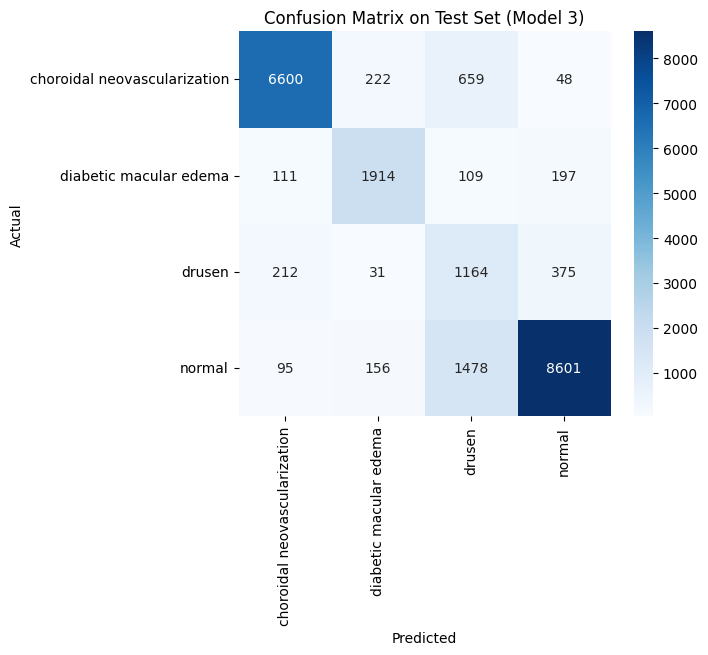

In [78]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model3.load_state_dict(torch.load("best_model3.pth"))
model3.eval()  # set to evaluation mode

all_preds_3 = []
all_labels_3 = []


with torch.no_grad():  # no gradient needed for testing
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model3(imgs)
        _, predicted_3 = torch.max(outputs, 1)  # get class with highest score
        all_preds_3.extend(predicted_3.cpu().numpy())
        all_labels_3.extend(labels.cpu().numpy())

all_preds_3 = np.array(all_preds_3)
all_labels_3 = np.array(all_labels_3)



# Accuracy
test_acc_3 = accuracy_score(all_labels_3, all_preds_3)
precision_3, recall_3, f1_3, _ = precision_recall_fscore_support(all_labels_3, all_preds_3, average='weighted')

print(f"Test Accuracy (Model 3): {test_acc_3:.4f}")
print(f"Precision: {precision_3:.4f}, Recall: {recall_3:.4f}, F1 Score: {f1_3:.4f}")

# Confusion Matrix
cm_3 = confusion_matrix(all_labels_3, all_preds_3)
plt.figure(figsize=(6,5))
sns.heatmap(cm_3, annot=True, fmt='d',
            xticklabels=list(info['label'].values()),
            yticklabels=list(info['label'].values()), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set (Model 3)')
plt.show()



In [79]:
import torch

# model is your PyTorch model
with open("a0_part_3_weights_50669456.pkl", "wb") as f:
    torch.save(model3.state_dict(), f)


In [80]:
torch.save(model3.state_dict(), "model3.pt")


1️⃣ Visualizing Convolutional Layer Outputs (Feature Maps)

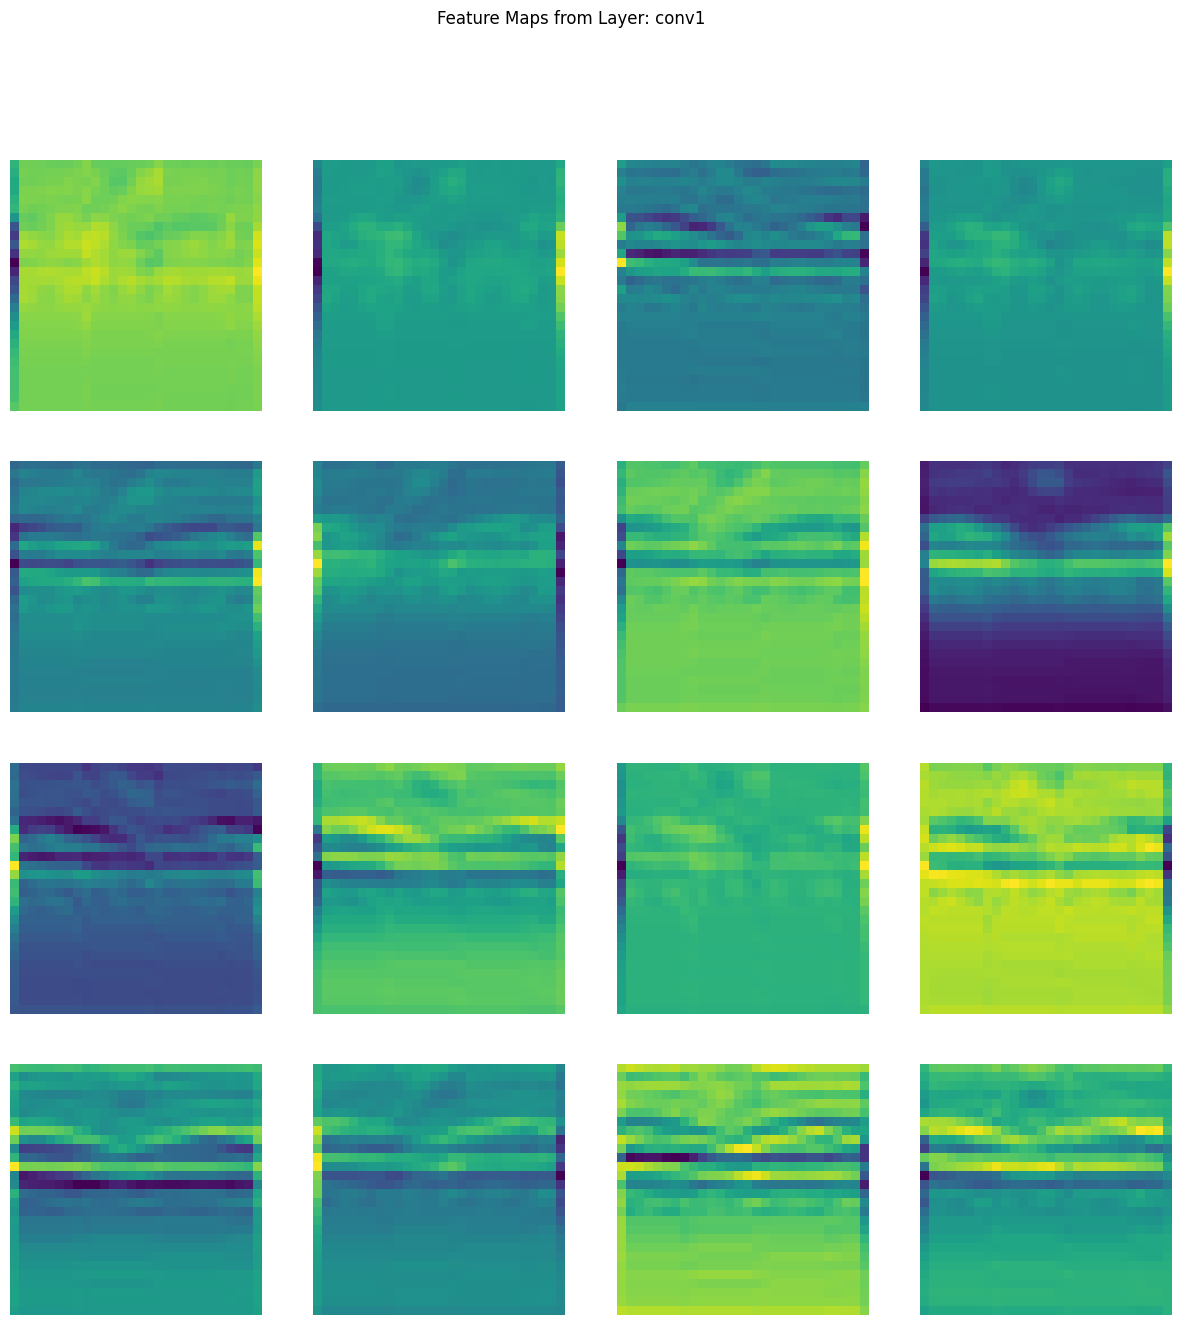

In [82]:
import torch
import matplotlib.pyplot as plt


sample_imgs, _ = next(iter(test_loader))
sample_img = sample_imgs[0:1].to(device)  # tKeeping the first image


activation_maps = {}


def get_activation(name):
    def hook(model, input, output):
        activation_maps[name] = output.detach()
    return hook

# Register hooks declared for selected layers (example: conv1, conv2, conv3)

#Since we have used conv3 only in model3 we are going with that
model3.conv1.register_forward_hook(get_activation('conv1'))
model3.conv2.register_forward_hook(get_activation('conv2'))
model3.conv3.register_forward_hook(get_activation('conv3'))

# Forward pass
model3.eval()
with torch.no_grad():
    _ = model3(sample_img)

#feature maps for each layer
for layer_name, fmap in activation_maps.items():
    num_filters = fmap.shape[1]  # number of channels
    plt.figure(figsize=(15, 15))
    for i in range(min(16, num_filters)):  # show up to 16 filters
        plt.subplot(4, 4, i+1)
        plt.imshow(fmap[0, i].cpu(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature Maps from Layer: {layer_name}")
    plt.show()


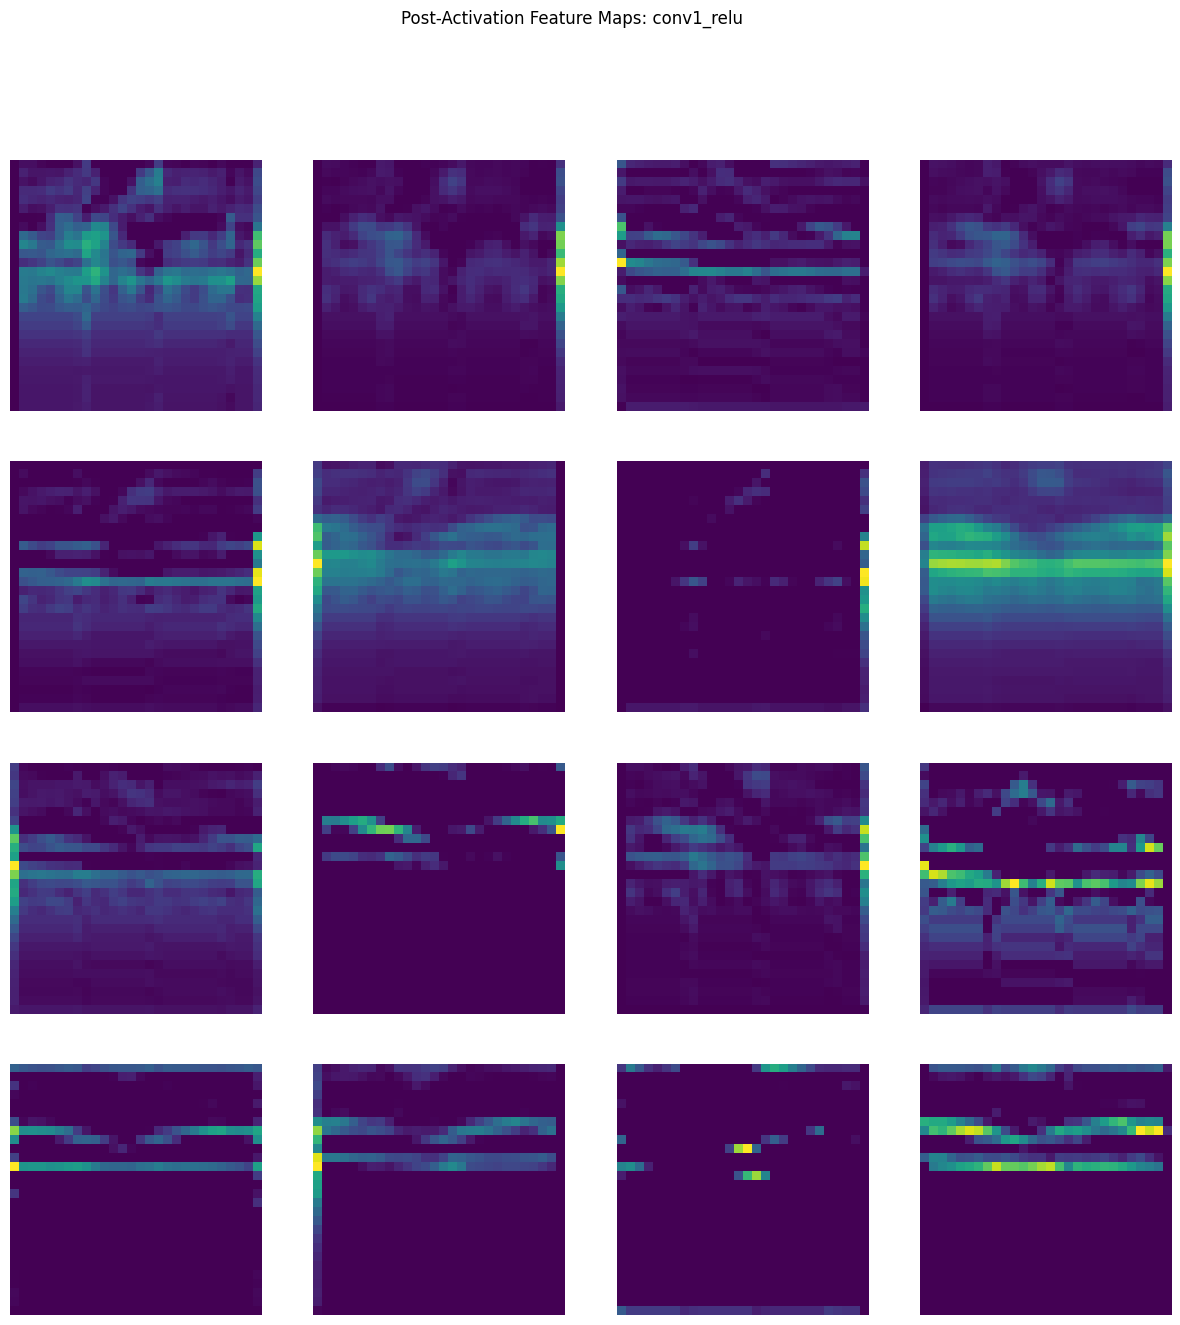

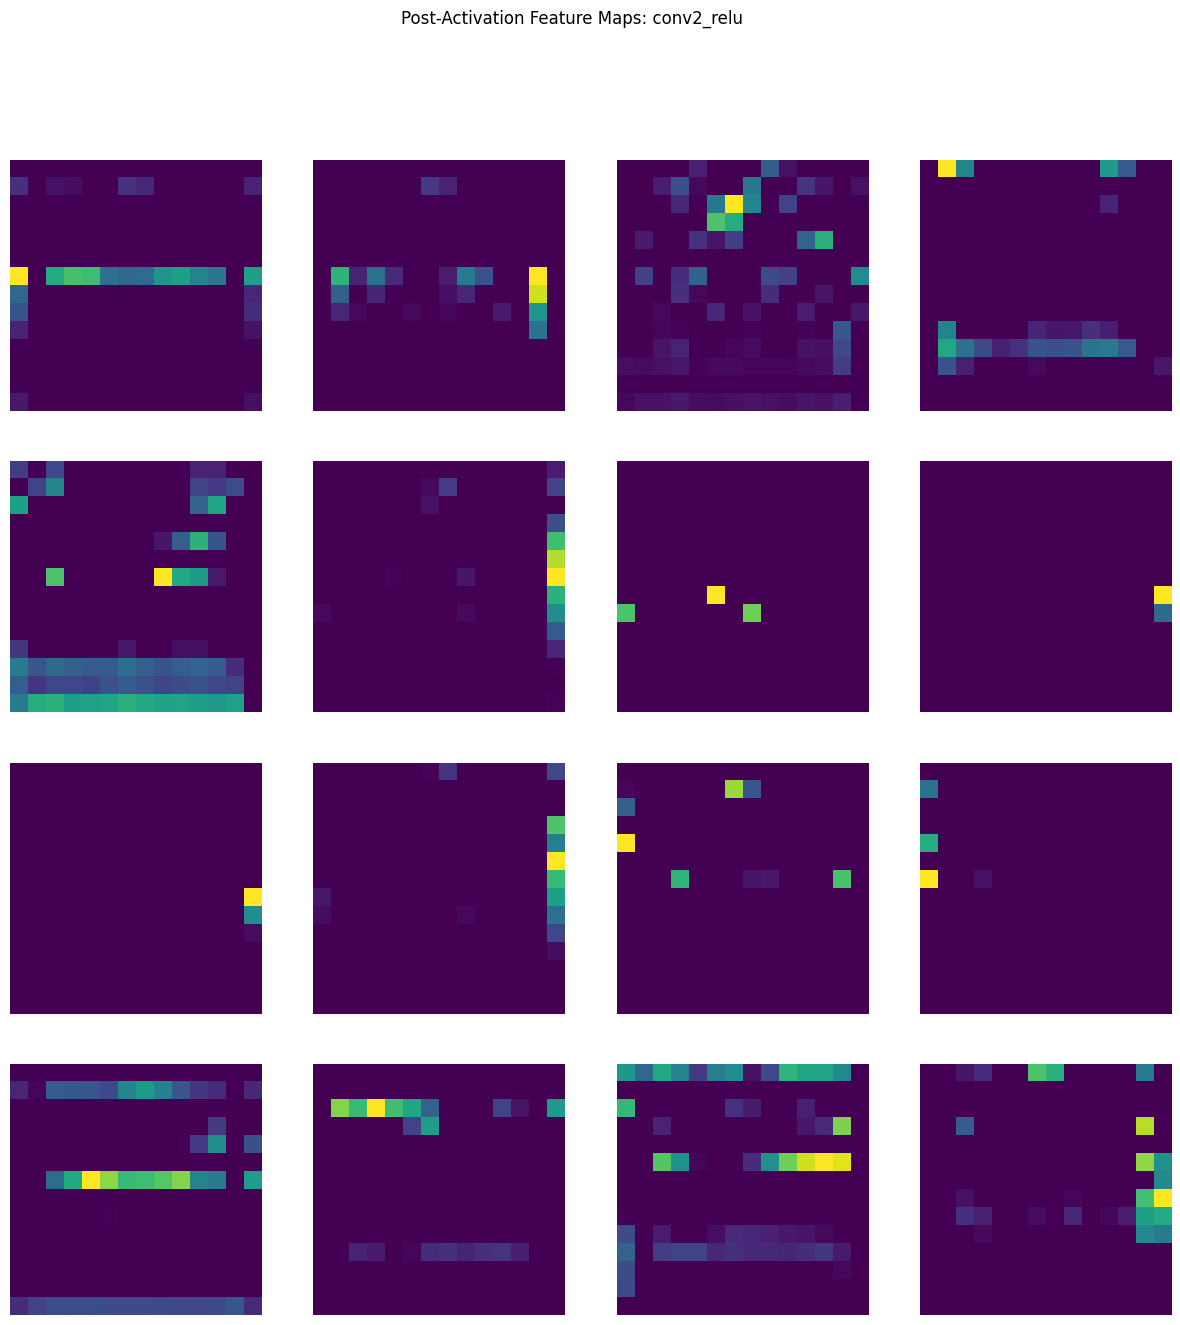

In [81]:
activation_maps_relu = {}

def get_activation_relu(name):
    def hook(model, input, output):
        # Applying  ReLU to see the result after post activation
        activation_maps_relu[name] = torch.relu(output).detach()
    return hook

model3.conv1.register_forward_hook(get_activation_relu('conv1_relu'))
model3.conv2.register_forward_hook(get_activation_relu('conv2_relu'))

# Forward pass
with torch.no_grad():
    _ = model3(sample_img)

# Visualize
for layer_name, fmap in activation_maps_relu.items():
    num_filters = fmap.shape[1]
    plt.figure(figsize=(15, 15))
    for i in range(min(16, num_filters)):
        plt.subplot(4, 4, i+1)
        plt.imshow(fmap[0, i].cpu(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Post-Activation Feature Maps: {layer_name}")
    plt.show()


In [83]:
#First layer we are using as mentioned
kernels = model.conv1.weight.data.cpu()

num_kernels = kernels.shape[0]  # number of filters
plt.figure(figsize=(15, 15))
for i in range(min(16, num_kernels)):
    plt.subplot(4, 4, i+1)
    plt.imshow(kernels[i, 0], cmap='gray')  # channel 0 if grayscale
    plt.axis('off')
plt.suptitle("Kernels of Conv1 (First Layer)")
plt.show()


References
1. https://medmnist.com/
2. https://github.com/MedMNIST/MedMNIST
3. https://docs.python.org/3/library/pprint.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
5. https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html